In [1]:
# Import libraries
import cv2
import os
import shutil
import numpy as np
import mahotas
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

# Split Dataset to Train & Testing (Run 2 times Only) change fromName with augmented_1 & augmented 2

In [2]:
# fromName = 'augmented_2'
# toName = 'augmented_2_split'
# classes = os.listdir('./' + fromName)
# names = classes
# for name in names:
#     if not os.path.exists("./" + toName + "/train/" + name):
#         os.makedirs("./" + toName + "/train/" + name)
#         os.makedirs("./" + toName + "/test/" + name)
# ii = 0
# for classe in classes:
#     # Construct the directory path for the current class
#     class_dir = './' + fromName + '/' + classe

#     # Check if the path is a directory
#     if not os.path.isdir(class_dir):
#         # If not, skip to the next class
#         continue

#     tempDic = os.listdir(class_dir)
#     tempLength = int(0.8 * len(tempDic))
#     src = './' + fromName + '/' + classe
#     dist1 = './' + toName + '/train/' + classe
#     dist2 = './' + toName + '/test/' + classe
#     ii += 1
#     for i in range(len(tempDic)):
#         if tempDic[i] == '.DS_Store':
#             continue  # Skip .DS_Store files
#         if i < tempLength:
#             shutil.copy(src + '/' + tempDic[i], dist1 + '/' + tempDic[i])
#         else:
#             shutil.copy(src + '/' + tempDic[i], dist2 + '/' + tempDic[i])


# Load Dataset

In [3]:
# Directories
train_path_aug1 = './augmented_1_split/train'
test_path_aug1 = './augmented_1_split/test'
train_path_aug2 = './augmented_2_split/train'
test_path_aug2 = './augmented_2_split/test'

# Image Segmentation, Extract Features, Loading Dataset

In [4]:
# Image segmentation for green and brown regions
def img_segmentation(rgb_img, hsv_img):
    # Green mask (healthy regions)
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Brown mask (disease regions)
    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)

    # Combine both masks
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

# Function to extract features
def extract_features(image):
    # Resize image agar lebih kecil dan hemat memori
    image_resized = cv2.resize(image, (128, 128))  # Ubah ukuran menjadi 128x128

    # Preprocess: Konversi warna dan segmentasi
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

    # Segmentasi hijau dan cokelat
    segmented_image = img_segmentation(image_rgb, image_hsv)

    # 1. Hu Moments
    gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(gray_segmented)).flatten()

    # 2. Haralick Features
    haralick = mahotas.features.haralick(gray_segmented).mean(axis=0)

    # 3. Histogram dari RGB dengan bins yang lebih sedikit
    hist_features = cv2.calcHist(
        [segmented_image], 
        [0, 1, 2], 
        None, 
        [8, 8, 8],  # Menggunakan 32 bins
        # [32, 32, 32],  # Menggunakan 32 bins
        [0, 256, 0, 256, 0, 256]
    ).flatten()

    return hu_moments, haralick, hist_features

def load_dataset(directory):
    hu_list, haralick_list, hist_list, labels = [], [], [], []

    for label in os.listdir(directory):  # Loop through class directories
        if label == '.DS_Store':
            continue  # Skip macOS system files
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue  # Skip if it's not a directory
        for img_file in os.listdir(label_path):  # Loop through images
            if img_file == '.DS_Store':
                continue  # Skip macOS system files
            img_path = os.path.join(label_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:  # Ensure the image is loaded correctly
                # Extract features from the image
                hu, haralick, hist = extract_features(image)
                hu_list.append(hu)
                haralick_list.append(haralick)
                hist_list.append(hist)
                labels.append(label)
            else:
                print(f"Warning: Unable to load image {img_path}")
    
    # Convert lists to NumPy arrays
    return np.array(hu_list), np.array(haralick_list), np.array(hist_list), np.array(labels)

# Loading Dataset for training

In [5]:
# Load datasets for both augmented splits
hu_train_1, haralick_train_1, hist_train_1, y_train_1 = load_dataset(train_path_aug1)
hu_test_1, haralick_test_1, hist_test_1, y_test_1 = load_dataset(test_path_aug1)

hu_train_2, haralick_train_2, hist_train_2, y_train_2 = load_dataset(train_path_aug2)
hu_test_2, haralick_test_2, hist_test_2, y_test_2 = load_dataset(test_path_aug2)

# Encode Labels, Scaler, Feature Combinations

In [6]:
# Encode Labels
encoder = LabelEncoder()
y_train_1_encoded = encoder.fit_transform(y_train_1)
y_test_1_encoded = encoder.transform(y_test_1)

y_train_2_encoded = encoder.fit_transform(y_train_2)
y_test_2_encoded = encoder.transform(y_test_2)

# Scale Features
scaler = MinMaxScaler()


# Feature combinations dictionary dengan dataset 2 juga
feature_combinations = {
    # Dataset Aug 1 - Fitur Individu
    "Hu Moments - Aug 1": (hu_train_1, hu_test_1),
    "Haralick Features - Aug 1": (haralick_train_1, haralick_test_1),
    "Histogram - Aug 1": (hist_train_1, hist_test_1),
    
    # Dataset Aug 2 - Fitur Individu
    "Hu Moments - Aug 2": (hu_train_2, hu_test_2),
    "Haralick Features - Aug 2": (haralick_train_2, haralick_test_2),
    "Histogram - Aug 2": (hist_train_2, hist_test_2),

    # Dataset Aug 1 - Kombinasi Fitur
    "Hu + Haralick - Aug 1": (
        np.hstack([hu_train_1, haralick_train_1]),
        np.hstack([hu_test_1, haralick_test_1])
    ),
    "Hu + Histogram - Aug 1": (
        np.hstack([hu_train_1, hist_train_1]),
        np.hstack([hu_test_1, hist_test_1])
    ),
    "Histogram + Haralick - Aug 1": (
        np.hstack([hist_train_1, haralick_train_1]),
        np.hstack([hist_test_1, haralick_test_1])
    ),
    "All Features - Aug 1": (
        np.hstack([hu_train_1, haralick_train_1, hist_train_1]),
        np.hstack([hu_test_1, haralick_test_1, hist_test_1])
    ),

    # Dataset Aug 2 - Kombinasi Fitur
    "Hu + Haralick - Aug 2": (
        np.hstack([hu_train_2, haralick_train_2]),
        np.hstack([hu_test_2, haralick_test_2])
    ),
    "Hu + Histogram - Aug 2": (
        np.hstack([hu_train_2, hist_train_2]),
        np.hstack([hu_test_2, hist_test_2])
    ),
    "Histogram + Haralick - Aug 2": (
        np.hstack([hist_train_2, haralick_train_2]),
        np.hstack([hist_test_2, haralick_test_2])
    ),
    "All Features - Aug 2": (
        np.hstack([hu_train_2, haralick_train_2, hist_train_2]),
        np.hstack([hu_test_2, haralick_test_2, hist_test_2])
    )
}



# Modelling

In [7]:
# Initialize models
svm = SVC(kernel='linear')

# Header with fixed column width
print("Comparison of Feature Combinations and Model Accuracy:")
header = f"{'Feature Combination':<30}{'SVM (Dataset 1)':<20}{'SVM (Dataset 2)':<20}"
print(header)
print("-" * len(header))

# Loop over all feature combinations and train with both datasets
for name, (X_train, X_test) in feature_combinations.items():
    
    # Scale the features
    X_train_scaled_1 = scaler.fit_transform(X_train)
    X_test_scaled_1 = scaler.transform(X_test)

    # Train and evaluate on Dataset 1
    svm.fit(X_train_scaled_1, y_train_1_encoded)
    y_pred_svm_1 = svm.predict(X_test_scaled_1)
    acc_svm_1 = accuracy_score(y_test_1_encoded, y_pred_svm_1)

    # Scale the features for second dataset
    X_train_scaled_2 = scaler.fit_transform(X_train)
    X_test_scaled_2 = scaler.transform(X_test)

    # Train and evaluate on Dataset 2
    svm.fit(X_train_scaled_2, y_train_2_encoded)
    y_pred_svm_2 = svm.predict(X_test_scaled_2)
    acc_svm_2 = accuracy_score(y_test_2_encoded, y_pred_svm_2)

    # Print comparison results
    row = f"{name:<30}{acc_svm_1:<20.4f}{acc_svm_2:<20.4f}"
    print(row)


Comparison of Feature Combinations and Model Accuracy:
Feature Combination           SVM (Dataset 1)     SVM (Dataset 2)     
----------------------------------------------------------------------
Hu Moments - Aug 1            0.0574              0.0574              
Haralick Features - Aug 1     0.3814              0.3814              
Histogram - Aug 1             0.6214              0.6214              
Hu Moments - Aug 2            0.0640              0.0640              
Haralick Features - Aug 2     0.4157              0.4157              
Histogram - Aug 2             0.6630              0.6630              
Hu + Haralick - Aug 1         0.3966              0.3966              
Hu + Histogram - Aug 1        0.6312              0.6312              
Histogram + Haralick - Aug 1  0.7176              0.7176              
All Features - Aug 1          0.7243              0.7243              
Hu + Haralick - Aug 2         0.4369              0.4369              
Hu + Histogram - Aug 2

| Label                                  | Encoded Value |
|----------------------------------------|---------------|
| Apple___Apple_scab                     | 0             |
| Apple___Black_rot                      | 1             |
| Apple___Cedar_apple_rust               | 2             |
| Apple___healthy                        | 3             |
| Blueberry___healthy                    | 4             |
| Cherry_(including_sour)___healthy      | 5             |
| Cherry_(including_sour)___Powdery_mildew | 6           |
| Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot | 7 |
| Corn_(maize)___Common_rust_            | 8             |
| Corn_(maize)___healthy                 | 9             |
| Corn_(maize)___Northern_Leaf_Blight    | 10            |
| Grape___Black_rot                      | 11            |
| Grape___Esca_(Black_Measles)           | 12            |
| Grape___healthy                        | 13            |
| Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | 14         |
| Orange___Haunglongbing_(Citrus_greening) | 15          |
| Peach___Bacterial_spot                 | 16            |
| Peach___healthy                        | 17            |
| Pepper,_bell___Bacterial_spot          | 18            |
| Pepper,_bell___healthy                 | 19            |
| Potato___Early_blight                  | 20            |
| Potato___healthy                       | 21            |
| Potato___Late_blight                   | 22            |
| Raspberry___healthy                    | 23            |
| Soybean___healthy                      | 24            |
| Squash___Powdery_mildew                | 25            |
| Strawberry___healthy                   | 26            |
| Strawberry___Leaf_scorch               | 27            |
| Tomato___Bacterial_spot                | 28            |
| Tomato___Early_blight                  | 29            |
| Tomato___healthy                       | 30            |
| Tomato___Late_blight                   | 31            |
| Tomato___Leaf_Mold                     | 32            |
| Tomato___Septoria_leaf_spot            | 33            |
| Tomato___Spider_mites_Two-spotted_spider_mite | 34     |
| Tomato___Target_Spot                   | 35            |
| Tomato___Tomato_mosaic_virus           | 36            |
| Tomato___Tomato_Yellow_Leaf_Curl_Virus | 37            |


# Evaluation for each Dataset


Final Evaluation on All Features for Dataset 1 (SVM):
SVM Classification Report (Dataset 1):
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       252
           1       0.55      0.69      0.61       249
           2       0.75      0.77      0.76       220
           3       0.70      0.70      0.70       200
           4       0.73      0.84      0.78       200
           5       0.76      0.62      0.68       200
           6       0.70      0.64      0.67       171
           7       0.75      0.70      0.73       206
           8       0.86      0.88      0.87       200
           9       0.71      0.76      0.73       197
          10       0.99      1.00      1.00       200
          11       0.80      0.75      0.78       200
          12       0.86      0.83      0.85       200
          13       0.95      0.92      0.93       200
          14       0.78      0.94      0.85       254
          15       0.89      0.82      0.

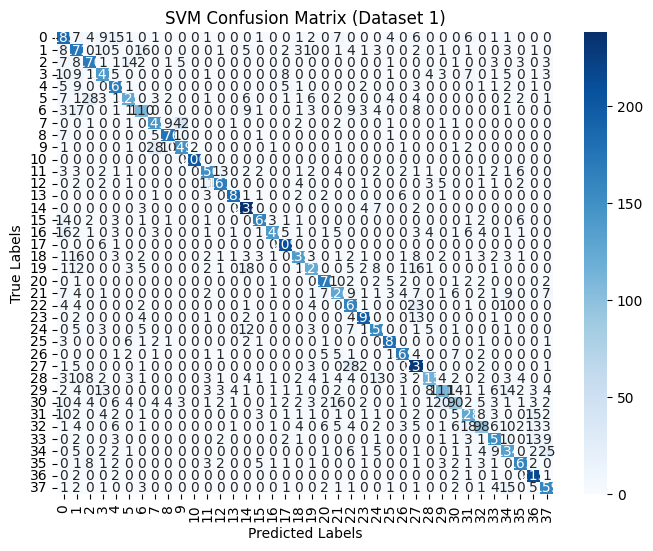


Final Evaluation on All Features for Dataset 2 (SVM):
SVM Classification Report (Dataset 2):
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       252
           1       0.55      0.69      0.61       249
           2       0.75      0.77      0.76       220
           3       0.70      0.70      0.70       200
           4       0.73      0.84      0.78       200
           5       0.76      0.62      0.68       200
           6       0.70      0.64      0.67       171
           7       0.75      0.70      0.73       206
           8       0.86      0.88      0.87       200
           9       0.71      0.76      0.73       197
          10       0.99      1.00      1.00       200
          11       0.80      0.75      0.78       200
          12       0.86      0.83      0.85       200
          13       0.95      0.92      0.93       200
          14       0.78      0.94      0.85       254
          15       0.89      0.82      0.

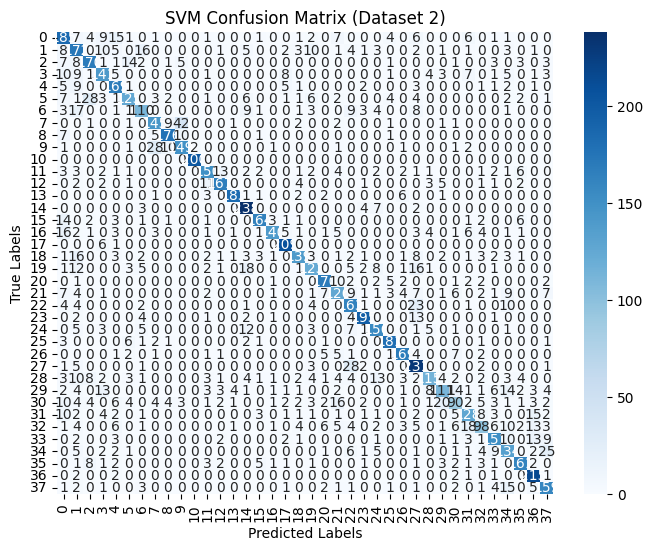

In [8]:
# Final Evaluation on All Features for SVM
print("\nFinal Evaluation on All Features for Dataset 1 (SVM):")
svm.fit(X_train_scaled_1, y_train_1_encoded)
y_pred_svm_1 = svm.predict(X_test_scaled_1)
print("SVM Classification Report (Dataset 1):")
print(classification_report(y_test_1_encoded, y_pred_svm_1))

# Plot Confusion Matrix for Dataset 1
conf_matrix_svm_1 = confusion_matrix(y_test_1_encoded, y_pred_svm_1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_1, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("SVM Confusion Matrix (Dataset 1)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nFinal Evaluation on All Features for Dataset 2 (SVM):")
svm.fit(X_train_scaled_2, y_train_2_encoded)
y_pred_svm_2 = svm.predict(X_test_scaled_2)
print("SVM Classification Report (Dataset 2):")
print(classification_report(y_test_2_encoded, y_pred_svm_2))

# Plot Confusion Matrix for Dataset 2
conf_matrix_svm_2 = confusion_matrix(y_test_2_encoded, y_pred_svm_2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_2, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("SVM Confusion Matrix (Dataset 2)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Saving Models for Both Datasets

In [9]:
# Train SVM and save models
svm.fit(X_train_scaled_1, y_train_1_encoded)
with open('svm_model_dataset1.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("SVM model for Dataset 1 saved.")

svm.fit(X_train_scaled_2, y_train_2_encoded)
with open('svm_model_dataset2.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("SVM model for Dataset 2 saved.")

SVM model for Dataset 1 saved.
SVM model for Dataset 2 saved.


# Loading Models for Both Datasets

In [10]:
# Load SVM models
with open('svm_model_dataset1.pkl', 'rb') as f:
    loaded_svm_dataset1 = pickle.load(f)
print("SVM model for Dataset 1 loaded.")

with open('svm_model_dataset2.pkl', 'rb') as f:
    loaded_svm_dataset2 = pickle.load(f)
print("SVM model for Dataset 2 loaded.")

SVM model for Dataset 1 loaded.
SVM model for Dataset 2 loaded.


# Using the Loaded Model for Prediction

In [11]:
# Use loaded SVM models for predictions
y_pred_svm_dataset1 = loaded_svm_dataset1.predict(X_test_scaled_1)
y_pred_svm_dataset2 = loaded_svm_dataset2.predict(X_test_scaled_2)

# Print sample results
original_labels_svm_dataset1 = encoder.inverse_transform(y_pred_svm_dataset1[:100])
original_labels_svm_dataset2 = encoder.inverse_transform(y_pred_svm_dataset2[:100])

print("Predictions using loaded SVM model for Dataset 1 (Original Labels):", original_labels_svm_dataset1)
print("Predictions using loaded SVM model for Dataset 2 (Original Labels):", original_labels_svm_dataset2)

Predictions using loaded SVM model for Dataset 1 (Original Labels): ['Strawberry___healthy' 'Pepper,_bell___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Apple___Black_rot' 'Potato___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Potato___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Tomato___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Potato___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Potato___healthy' 'Pepper,_bell___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Strawberry___healthy' 'Strawberry___healthy'
 'Strawberry___healthy' 'Potato___healthy